In [1]:
# import numpy & Math
import numpy as np
import math

# import PyTorch
import torch
import torch.nn.functional as F
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Improve quality of visualization
%config InlineBackend.figure_format = 'svg'

# Import seaborn for confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# import pandas df for datasets cleaning
import pandas as pd

#check versions
print(torch.__version__)
print(torchvision.__version__)

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.1.2+cu121
0.16.2+cu121


In [47]:
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from pathlib import Path
import zipfile
import os
import requests
import copy
import sys
from PIL import Image
import random

In [3]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std =[0.5]
        # mean=[0.5,0.5,0.5],
        # std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])


In [6]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.FashionMNIST(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)
test_data = torchvision.datasets.FashionMNIST(
                                root='./data', 
                                download=True, 
                                train=False, 
                                transform=transform)


100%|██████████| 26421880/26421880 [00:08<00:00, 3102136.83it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 408863.53it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2644290.81it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 9227468.80it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [7]:
test_data.data.shape


torch.Size([10000, 28, 28])

In [8]:
# Step 3: Split the testset into test & dev
randidx = np.random.permutation(10000)
dev_data = Subset(test_data, randidx[:4000])
test_data = Subset(test_data, randidx[4000:])


In [9]:
# Step 4: Translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=batchsize)
test_loader = DataLoader(test_data, batch_size=len(test_data))


In [10]:
# Number of images in each dataset
print(len(train_data))
print(len(dev_data))
print(len(test_data))


60000
4000
6000


In [11]:
# range of pixel intensity values
print(train_data.data.min().item(), train_data.data.max().item())


0 255


In [12]:
# unique class categories
print(train_data.classes)
print(len(train_data.classes))


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [13]:
# Check dimentions from train loader
# Therefore: transformations are ONLY applied when we pull data from train_loader
X, y = next(iter(train_loader))
print(X.data.shape)
# number of images * channels features * width * height


torch.Size([32, 1, 28, 28])


In [14]:
#check intesity from train loaders
# Therefore: transformations are ONLY applied when we pull data from train_loader
print(torch.min(X.data), torch.max(X.data))


tensor(-1.) tensor(1.)


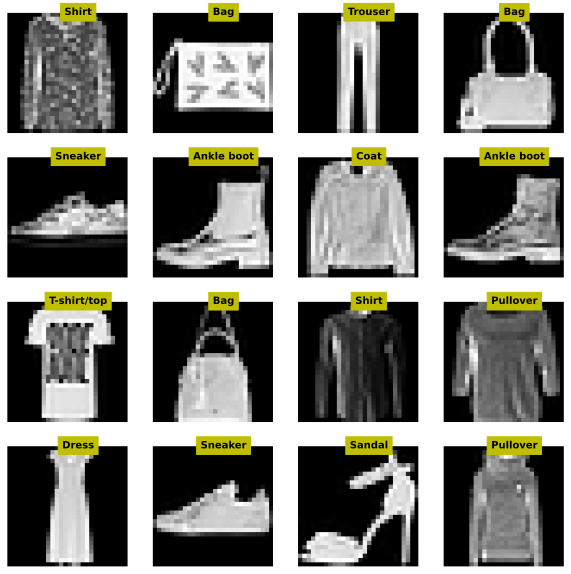

In [15]:
# check for a few random images
fix, axs = plt.subplots(4,4,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    
    #extract the image (transpose it back to 32x32x3) so matplot can understand it
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + 0.5 #undo normalization
    
    label = train_data.classes[y[i]]
    
    ax.imshow(pic, cmap='gray')
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')


In [16]:
train_loader.dataset.data[0][0].shape


torch.Size([28])

In [17]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            imgSize = train_loader.dataset.data[0].shape[0] #28
            inChans  = 1 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 0 # square if single input
            stride   = 1 # use maxpool instead of stride ... so stride = 1
            
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv2d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm2d(outChans) # 64
            outputSize = np.floor( (imgSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (28 + 2*0 - 3) / 1 ) + 1 = 26
            # output size = 26/2 = 13 b/c of pool
            
            # Second Convolution Layer
            self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm2d(outChans*2) # 128
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (13 + 2*0 - 3) / 1 ) + 1 = 11
            # output size = 11/2 = 5 b/c of pool
            
            # Third Convolution Layer
            # self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding)
            # self.bnorm3 = nn.BatchNorm2d(outChans*2*2) # 256
            # output size = floor( (5 + 2*0 - 3) / 1 ) + 1 = 3
            # output size = 3/2 = 1 b/c of avgpool

            ### ------- Linear Layer ------- ###
            # self.fc1 = nn.Linear(flattened_size,200) #1024, 256
            flattened_size = (outputSize**2) * (outChans*2)
            # print(flattened_size)
            self.fc1 = nn.Linear(int(flattened_size),200) #1024, 256
            self.fc2 = nn.Linear(200,50)
            self.fc3 = nn.Linear(50,10)
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = F.max_pool2d( self.conv1(x), 2)
            x = F.leaky_relu( self.bnorm1(x)  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = F.max_pool2d( self.conv2(x), 2)
            x = F.leaky_relu( self.bnorm2(x)  )
            if self.print: print(f'Second conv: {list(x.shape)}')

            # x = F.max_pool2d( self.conv3(x), 2)
            # x = F.leaky_relu( self.bnorm3(x)  )
            # if self.print: print(f'Third conv: {list(x.shape)}')

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.leaky_relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
            
            x = F.leaky_relu( self.fc2(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc2: {list(x.shape)}')
            
            x = self.fc3(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001,
                                weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer


In [18]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

X, y = next(iter(train_loader))

X = X.to(device)
y = y.to(device)

yHat = net2(X)

#check size of output
print(yHat.shape)

#compute the loss
loss = lossfun2(yHat, torch.squeeze(y))
print(loss)


Input: [32, 1, 28, 28]
First conv: [32, 64, 13, 13]
Second conv: [32, 128, 5, 5]
Vectorized: [32, 3200]
fc1: [32, 200]
fc2: [32, 50]
Final Output: [32, 10]
torch.Size([32, 10])
tensor(2.2963, device='cuda:0', grad_fn=<NllLossBackward0>)


In [28]:
# Train the Model

best_checkpoint = dict()
best_accuracy   = 0

def trainTheModel(trainedModel, lossfun, optimizer, epochs=20):
    global best_checkpoint, best_accuracy

    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    devLoss   = torch.zeros(numepochs)
    devAcc  = []
    
    for epochi in range(numepochs):
        
        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            batchLoss.append(loss.item())
            
            # accuracy from this batch for categorical data
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            batchAcc.append( torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc_epoch = 100 * np.mean((batchAcc))
        trainAcc.append(trainAcc_epoch)
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(batchLoss)
        
        if trainAcc_epoch > best_accuracy:
            best_accuracy   = trainAcc_epoch
            best_checkpoint['state_dict'] = copy.deepcopy(trainedModel.state_dict)()
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()

        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        #final forward pass for Test Accuracy
        # X,y = next(iter(dev_loader))
        for X, y in dev_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            batchLoss.append(loss.item())
            
            #batch acc
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            batchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        devLoss[epochi] = ( np.mean(batchLoss) )
        
        devAcc.append(100*np.mean(batchAcc))

        msg1 = f'Epoch = {epochi+1}/{epochs}, # '
        msg2 = f'TrainAcc = {trainAcc[-1]:0.2f}, # '
        msg3 = f'ValAcc   = {devAcc[-1]:0.2f} # '
        sys.stdout.write('\r' + msg1 + msg2 + msg3)

    return trainAcc, trainLoss, devAcc, devLoss, trainedModel


In [29]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet()
trainAcc2, trainLoss2, devAcc2, devLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)


Epoch = 1/1, # TrainAcc = 80.22, # ValAcc   = 87.25 # 

In [30]:
# Train the Model
epochs=15
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, devAcc, devLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer, epochs)

Epoch = 15/15, # TrainAcc = 97.17, # ValAcc   = 90.42 # 

In [ ]:
trainedModel.load_state_dict(best_checkpoint['state_dict'])
trainedModel_B, lossfun, optimizer = createTheNet()
trainedModel_B.load_state_dict(best_checkpoint['state_dict'])

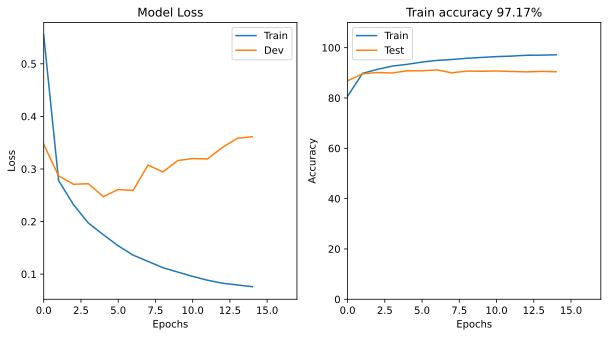

In [35]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
ax[0].plot(devLoss, label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlim([0,17])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(devAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
ax[1].set_xlim([0,17])

plt.show()


In [32]:
# run the real test set
trainedModel.eval()
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

#forward pass & loss
with torch.no_grad():
    yHat = trainedModel(X)
    loss = lossfun(yHat, y)
    
testLoss = loss.item()
    
testAccMatches = torch.argmax(yHat, axis=1)
testAccMatchesNumeric = (testAccMatches == y).float()
testAcc = ( 100 * torch.mean(testAccMatchesNumeric) ).item()


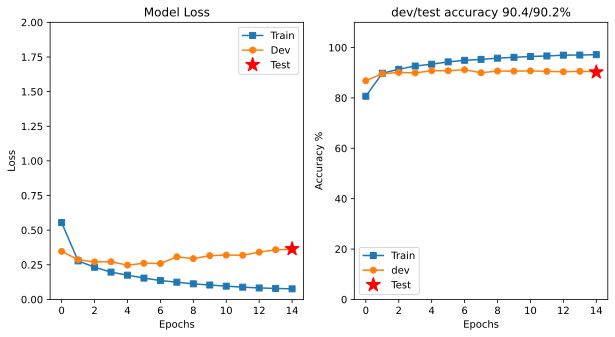

In [33]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, 's-' , label='Train')
ax[0].plot(devLoss,   'o-' ,label='Dev')
ax[0].plot(len(devLoss)-1, testLoss, 'r*', markersize=15, label='Test')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylim([0,2])



ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(devAcc,   'o-', label='dev')
ax[1].plot(len(devAcc)-1, testAcc, 'r*', markersize=15, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'dev/test accuracy {devAcc[-1]:0.1f}/{testAcc:0.1f}%')
ax[1].set_ylim([0,110])

plt.show()


In [50]:
summary(trainedModel)

Layer (type:depth-idx)                   Param #
cnnClassNet                              --
├─Conv2d: 1-1                            640
├─BatchNorm2d: 1-2                       128
├─Conv2d: 1-3                            73,856
├─BatchNorm2d: 1-4                       256
├─Linear: 1-5                            640,200
├─Linear: 1-6                            10,050
├─Linear: 1-7                            510
Total params: 725,640
Trainable params: 725,640
Non-trainable params: 0

In [51]:
trainedModel

cnnClassNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [54]:
model_size = sum(p.numel() * p.element_size() for p in trainedModel.parameters()) / (1024 ** 2)
print(f'{model_size:0.2f}MB')

2.77MB


In [55]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [56]:
sparsity = 0.9
pruner = FineGrainedPruner(trainedModel, sparsity)

NameError: name 'fine_grained_prune' is not defined